In [22]:
import math
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [23]:
columns = ['center','left', 'right', 'angle', 'throttle', 'break', 'speed']
df_main_track = pd.read_csv("main-track-normal-driving/driving_log.csv", names=columns)
df_main_edges = pd.read_csv("main-track-edges/driving_log.csv", names=columns)
df_main_udacity = pd.read_csv("main-track-udacity/driving_log.csv")
df_main_good_quality = pd.read_csv("main-track-good-quality/driving_log.csv", names=columns)
df_first = pd.read_csv("driving_log.csv", names=columns)

In [24]:
df_main_udacity['angle'] = df_main_udacity['steering']
path = '/Users/lacho/sdcnd/Self-Driving-Car-Simulator/main-track-udacity/'
df_main_udacity['center'] = path + df_main_udacity['center'].str.strip()
df_main_udacity['left'] = path + df_main_udacity['left'].str.strip()
df_main_udacity['right'] = path + df_main_udacity['right'].str.strip()

In [25]:
print(df_main_track.shape)
print(df_main_edges.shape)
print(df_main_udacity.shape)
print(df_main_good_quality.shape)
print(df_first.shape)

(9100, 7)
(5054, 7)
(8036, 8)
(2469, 7)
(22323, 7)


In [26]:
def get_data(df, add_side_camers=False):
    df_train = df[['center', 'angle']]

    if add_side_camers:
        df_left = pd.DataFrame({'center': df.left[df.angle >= 0].values, 'angle': df.angle[df.angle >= 0].values + 0.1})
        df_right = pd.DataFrame({'center': df.right[df.angle <= 0].values, 'angle': df.angle[df.angle <= 0].values - 0.1})
        df_train = df_train.append(df_left, ignore_index=True);
        df_train = df_train.append(df_right, ignore_index=True);
    return df_train

In [27]:
df_train = get_data(df_main_track)
df_train = df_train.append(get_data(df_main_udacity))
df_train = df_train.append(get_data(df_main_good_quality))
df_train = df_train.append(get_data(df_main_edges, False))
df_train = df_train.append(get_data(df_first, False))

df_train.center = df_train.center.str.strip()
print(df_train.shape)

(46982, 2)


In [28]:
df_train.to_csv('train.csv',index=False)

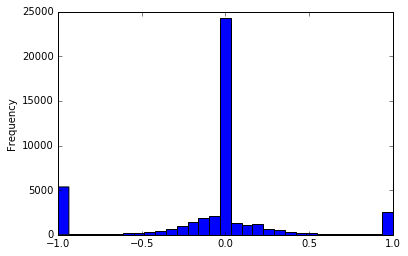

In [29]:
df_train.angle.plot(kind='hist', bins=31)

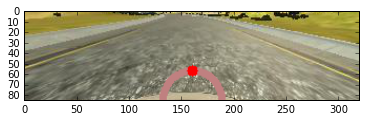

In [16]:
def load_img(path, resize=True, crop_top=20, crop_bottom=-1):
    img = cv2.imread(path)

    if resize:
        img = cv2.resize(img,(160, 80), interpolation = cv2.INTER_CUBIC)
    if crop_top:
        img = img[crop_top:crop_bottom, :] 
    return img 

def draw_circle(img, angle_r):
    height, width  = img.shape[0:2]
    radius = int(height/3)
    dot_size = int(height / 16)
    img = cv2.circle(img, (int(width/2), height), radius, (128,128,192), dot_size)
    x = width / 2 + radius * angle_r
    y = height - radius * (1 - abs(angle_r))
    img = cv2.circle(img, (int(x), int(y)), dot_size, (0,0, 256), -1)
    return img

def convert_img_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show_img(img, new_figure=True):
    if new_figure:
        plt.figure()
    plt.imshow(convert_img_rgb(img));
    

def ld_img(img):
#     return load_img(img, resize=False, crop_top=65, crop_bottom=-20)
#     return load_img(img, resize=True, crop_top=30, crop_bottom=-10)
    return load_img(img, resize=False, crop_top=60, crop_bottom=-15)


def video_pipeline(row):
    return convert_img_rgb(draw_circle(ld_img(row['center']), row['angle'] ))

i = -4112
img_path = df_train.center.iloc[i]
angle = df_train.angle.iloc[i]
img = ld_img(img_path)

img = draw_circle(img, angle)
show_img(img)

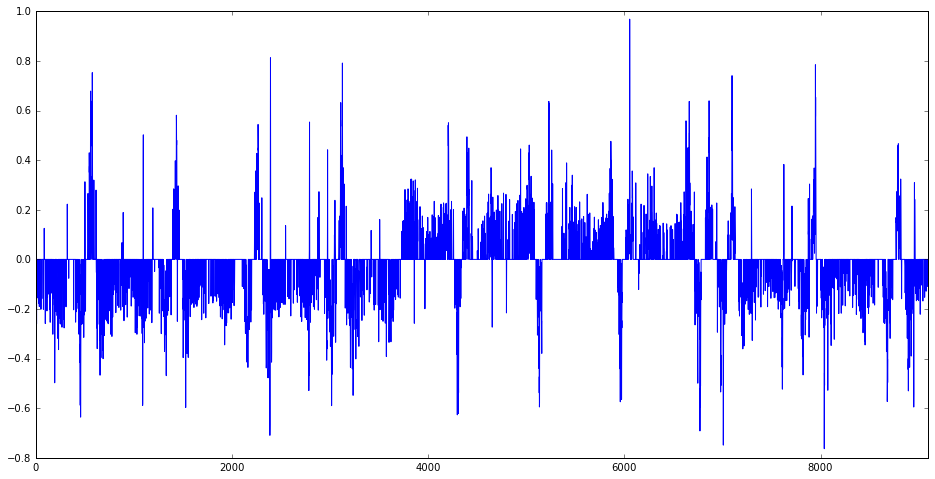

In [19]:
# Plot angles
plt.figure(figsize=(16,8))
df_main_track.angle.plot()

In [20]:
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML

In [24]:
file_name = "train.mp4"
frames = list([video_pipeline(f[1]) for f in df_train.iterrows()])
new_clip = ImageSequenceClip(frames, fps=30)
new_clip.write_videofile(file_name) 

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_name))

[MoviePy] >>>> Building video train.mp4
[MoviePy] Writing video train.mp4


100%|██████████| 25067/25067 [02:20<00:00, 178.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: train.mp4 



In [ ]:
df_sim = pd.read_csv("simulator_imgs/data.csv", names=['center','angle'])

In [ ]:
def ld_img(img):
    return load_img(img, resize=False, crop_top=0, normalize=False, crop_bottom=-1)

file_name = "simulator.mp4"
frames = list([video_pipeline(f[1]) for f in df_sim.iterrows()])
new_clip = ImageSequenceClip(frames, fps=30)
new_clip.write_videofile(file_name) 

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(file_name))